#### CUDA SETTINGS

In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

#### IMPORTS

In [2]:
from src.reproduce.reproduce_utils import call_cfg_key, reconstruct_from_config, eval_ose, plot_results
from omegaconf import OmegaConf
import datetime

#### IMPORTANT FILE PATHS

In [4]:
# downloaded cmems data
concatenated_6_nadirs_filepath = 'data/gridded/input_test_6sat_2023.nc'
test_1_nadir_filepath = 'data/concat/concatenated_ref_2023_reprocessed.nc'

# model hydra config
your_config = 'models/4dvarnet_glorys_10years/config.yaml'
# best model ckpt path
best_ckpt_path = 'models/4dvarnet_glorys_10years/val_mse=26.93737-epoch=018.ckpt'
# name of the dir under which the reconstructed files will be stored
your_rec_dir = 'rec_dir'

# reconstructed files will be stored in <your_rec_dir>/reproduce/version_0/
# careful, it will be version_1, 2, 3... instead of version_0 and so on if you use this notebook multiple times
REC_PATHS = your_rec_dir+'/reproduce/version_0/test_data_{}.nc'

#### CONFIG OVERRIDES

In [5]:
# min and max time of REFERENCE DATA
min_time="2023-01-01"
max_time="2023-12-31"

In [6]:
min_time_date = datetime.datetime.strptime(min_time, '%Y-%m-%d')
max_time_date = datetime.datetime.strptime(max_time, '%Y-%m-%d')

time_offset = datetime.timedelta(days=15)

min_time_offset = min_time_date + time_offset
max_time_offset = max_time_date - time_offset

min_time_offset_str = min_time_offset.strftime('%Y-%m-%d')
max_time_offset_str = max_time_offset.strftime('%Y-%m-%d')

print('min/max time: {} / {}\nmin/max offseted time: {} / {}'.format(min_time, max_time, min_time_offset_str, max_time_offset_str))

min/max time: 2023-01-01 / 2023-12-31
min/max offseted time: 2023-01-16 / 2023-12-16


#### LOADING CONFIG (and overriding with your information)

In [6]:
config = OmegaConf.load(your_config)
OmegaConf.set_struct(config, True)

# override path to cmems input data
OmegaConf.update(config, key='paths.ose_6_sats', value=concatenated_6_nadirs_filepath)

# override output path of reconstructed paths
OmegaConf.update(config, key='trainer.logger.save_dir', value=your_rec_dir)

# override time necessary time values in config
OmegaConf.update(config, key='datamodule.domains.train.time._args_', value=[min_time, min_time_offset_str])
OmegaConf.update(config, key='datamodule.domains.val.time._args_', value=[min_time, min_time_offset_str])

#full_time allocated to the test dataset
OmegaConf.update(config, key='datamodule.domains.test.time._args_', value=[min_time, max_time])

# pre metric fn is applied to a a window cropped on each side by 15 days
OmegaConf.update(config, key='model.pre_metric_fn.time._args_', value=[min_time_offset_str, max_time_offset_str])

### PREDICT WITH MODEL:

/DATASET/envs/p24hasle/miniconda/envs/repro_env/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /DATASET/envs/p24hasle/miniconda/envs/repro_env/lib/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 333


test_regrid: None


Restoring states from the checkpoint path at models/4dvarnet_glorys_10years/val_mse=26.93737-epoch=018.ckpt


Norm stats (0.48749464750289917, 0.4605884253978729)
dataset sizes
dataset length
dataset sizes
dataset length
dataset sizes
dataset length


/DATASET/envs/p24hasle/miniconda/envs/repro_env/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.4, which is newer than your current Lightning version: v2.0.9
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
Loaded model weights from the checkpoint at models/4dvarnet_glorys_10years/val_mse=26.93737-epoch=018.ckpt


Testing DataLoader 0: 100%|██████████| 85/85 [00:18<00:00,  4.53it/s]rec_dir/test_data_0.nc
rec_dir/test_data_1.nc
rec_dir/test_data_2.nc
rec_dir/test_data_3.nc
rec_dir/test_data_4.nc
rec_dir/test_data_5.nc
rec_dir/test_data_6.nc
rec_dir/test_data_7.nc
rec_dir/test_data_8.nc
rec_dir/test_data_9.nc
rec_dir/test_data_10.nc
rec_dir/test_data_11.nc
rec_dir/test_data_12.nc
rec_dir/test_data_13.nc
rec_dir/test_data_14.nc
rec_dir/test_data_15.nc
rec_dir/test_data_16.nc
rec_dir/test_data_17.nc
rec_dir/test_data_18.nc
rec_dir/test_data_19.nc
|     |       -13 |       -12 |       -11 |      -10 |        -9 |        -8 |        -7 |        -6 |        -5 |        -4 |        -3 |        -2 |      -1 |         0 |         1 |         2 |         3 |         4 |         5 |         6 |
|:----|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|----------:|--------

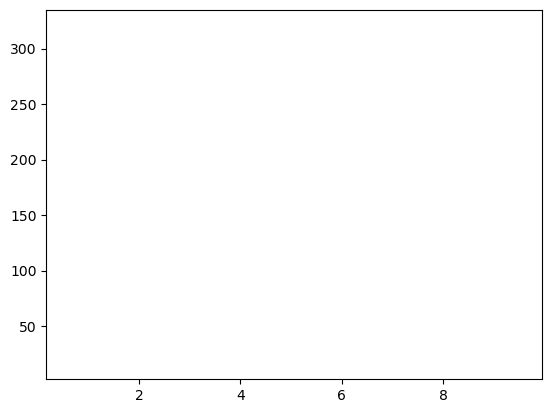

In [7]:
reconstruct_from_config(config, your_rec_dir, best_ckpt_path)

### OSE RESULTS:

In [7]:
lead_times = range(13,20)

RMSE_array = []

for lead_time in lead_times:
    a,b = eval_ose(
        path_alongtrack = test_1_nadir_filepath,
        path_rec = REC_PATHS.format(lead_time),
        time_min = min_time_offset_str,
        time_max= max_time_offset_str
    )

    print('leadtime {} - RMSE: {:.4f} | PSD: {:.4f}'.format(lead_time-lead_times[0], a, b))
    RMSE_array.append(a)

leadtime 0 - RMSE: 0.7953 | PSD: 18.0000
leadtime 1 - RMSE: 0.7716 | PSD: 17.0000
leadtime 2 - RMSE: 0.7250 | PSD: 17.0000
leadtime 3 - RMSE: 0.7020 | PSD: 17.0000
leadtime 4 - RMSE: 0.6600 | PSD: 16.0000
leadtime 5 - RMSE: 0.6693 | PSD: 17.0000
leadtime 6 - RMSE: 0.5968 | PSD: 13.0000


#### PLOT RESULTS (<html><span style="color:red">RED</span></html> on graph)

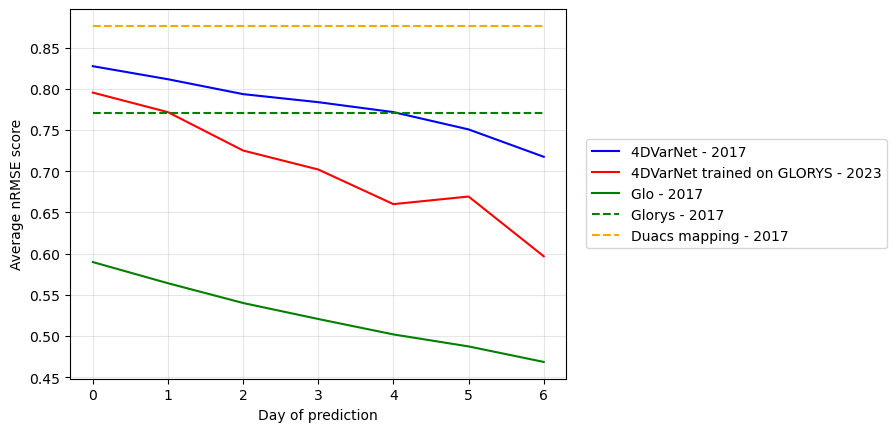

In [8]:
# save_name: named of saved graph if not None
plot_results(RMSE_array, save_name=None, your_year=min_time_date.strftime('%Y'))